# Dataset Builder
This file is used to generate dataset used for model training from given csv file

In [1]:
import numpy as np
import csv
import json
import random
import h5py
from Settings import Settings
from FileUtils import FileUtils

## Read CSV File

In [2]:
csv_file = open(Settings.data_path, "r")
csv_reader = csv.reader(csv_file)

data_list = list() # contains data
label_dict = dict() # assign index to labels
label_index = 0

vocab = set()
word_freq = dict()
sentenceLength = dict()  # used for statistic analysis

# notice label indices and word indices are both start from 1

for line in csv_reader:
    label, doc = line
    words = doc.strip().split()
    sentenceLength[len(words)] = sentenceLength.get(len(words), 0) + 1
    if not label_dict.get(label):
        label_index += 1
        label_dict[label] = label_index
        
    for word in words:
        vocab.add(word)
        word_freq[word] = word_freq.get(word, 0) + 1
        
    data_list.append([label_dict.get(label), words])
        
csv_file.close()

In [3]:
print(label_dict)

{'DELETION OF INTEREST': 1, 'RETURNED CHECK': 2, 'BILL': 3, 'POLICY CHANGE': 4, 'CANCELLATION NOTICE': 5, 'DECLARATION': 6, 'CHANGE ENDORSEMENT': 7, 'NON-RENEWAL NOTICE': 8, 'BINDER': 9, 'REINSTATEMENT NOTICE': 10, 'EXPIRATION NOTICE': 11, 'INTENT TO CANCEL NOTICE': 12, 'APPLICATION': 13, 'BILL BINDER': 14}


In [4]:
label_idx_dict = dict()
for key in label_dict:
    label_idx_dict[label_dict.get(key)] = key

In [5]:
print(label_idx_dict)

{1: 'DELETION OF INTEREST', 2: 'RETURNED CHECK', 3: 'BILL', 4: 'POLICY CHANGE', 5: 'CANCELLATION NOTICE', 6: 'DECLARATION', 7: 'CHANGE ENDORSEMENT', 8: 'NON-RENEWAL NOTICE', 9: 'BINDER', 10: 'REINSTATEMENT NOTICE', 11: 'EXPIRATION NOTICE', 12: 'INTENT TO CANCEL NOTICE', 13: 'APPLICATION', 14: 'BILL BINDER'}


## Store label Maps
For backup

In [6]:
FileUtils.save_dict(label_dict, "LabelToIndex.json")
FileUtils.save_dict(label_idx_dict, "IndexToLabel.json")

## Clean vocabulary
Since we statistics the freqency, we remove those words rarely show up

In [7]:
word_list = list(vocab)
new_vocab = vocab.copy()

for word in word_list:
    if word_freq.get(word) < 3:  # remove words only occurs twice in our original data
        new_vocab.remove(word)
print(len(vocab), len(new_vocab))

1037934 172658


In [8]:
# build word map
word_map = dict()
word_map["UNK"] = 0  # unknown word
word_map["PAD"] = 1  # padding word
for i, word in enumerate(list(new_vocab)):
    word_map[word] = i + 2

new_vocab.add("UNK")
new_vocab.add("PAD")
# save word map
FileUtils.save_dict(word_map, "WordToIndex.json")

In [9]:
print(len(word_map))

172660


## Index Original Data


In [10]:
inplace_list = data_list[:] # copy

for label, words in inplace_list:
    for i, word in enumerate(words):
        words[i] = word_map.get(word, 0)

In [11]:
print(inplace_list[0])

[1, [105216, 26156, 94360, 53298, 80810, 153337, 23216, 65233, 162768, 153739, 72130, 91321, 18651, 9149, 37808, 49918, 162497, 3433, 80810, 81681, 91321, 41366, 151153, 67070, 38814, 23216, 119413, 104030, 138062, 143687, 6600, 70699, 145427, 131418, 151498, 56227, 120966, 72130, 18651, 0, 62364, 36869, 21771, 166934, 56692, 15084, 99362, 91321, 167276, 29727, 148351, 110728, 88212, 85469, 148459, 103263, 92550, 74063, 138095, 20618, 141453, 105133, 61542, 91321, 153331, 72669, 71634, 133196, 58343, 60575, 70699, 87157, 159040, 119708, 41024, 141017, 148351, 141776, 141453, 2455, 29727, 78119, 148351, 167276, 141453, 110997, 105711, 138095, 29727, 34476, 71634, 162479, 26870, 61707, 141017, 148351, 97277, 29727, 148351, 146624, 78119, 71793, 105216, 94621, 83720, 86710, 34005, 65089, 134722, 87735, 62317, 22563, 79661, 86849, 45010, 35562, 45245, 145856, 61707, 69069, 30927, 1792, 65858, 43924, 71793, 141017, 151955, 0, 168453, 141453, 32001, 0, 52411, 168453, 86849, 45010, 35562, 452

## Divide documents into chunks

In [12]:
import matplotlib.pyplot as plt

In [13]:
# we need to determine how to slice the document
length = list(sentenceLength.keys())
freq = [sentenceLength.get(i) for i in length]

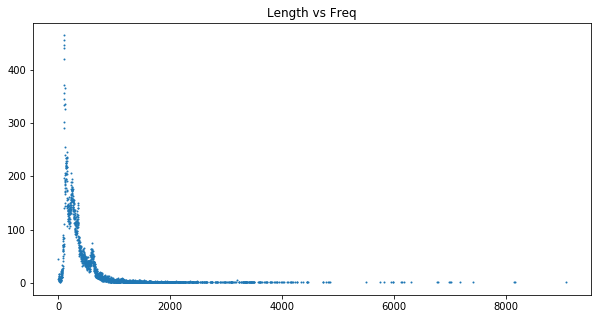

464


In [14]:
plt.figure(figsize=(10,5))
plt.scatter(length, freq, s=1)
plt.title("Length vs Freq")
plt.show()

print(max(freq))

In [15]:
# so I determined to divide each document to chunks contains 200 words, and padding if length < 200
print(Settings.seq_size)

200


In [16]:
records = list() # contains label/chunk pair
label_freq_dict = dict() # to see how many chunks belongs to one label

for label, words in inplace_list:
    sentences = FileUtils.divide_sentence(words, Settings.seq_size)
    for s in sentences:
        records.append([label, s])
        label_freq_dict[label] = label_freq_dict.get(label, list()) + [s]

In [17]:
print(len(records))

133989


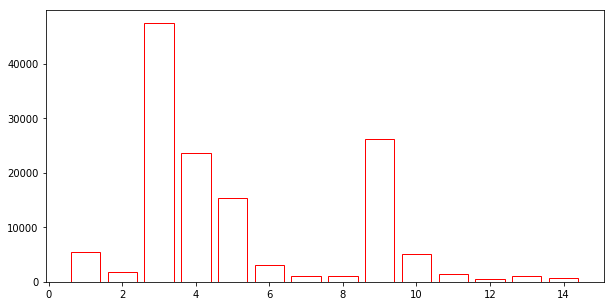

In [18]:
plt.figure(figsize=(10,5))
x = list(label_freq_dict.keys())
y = [len(label_freq_dict.get(key)) for key in x]

plt.bar(range(1, 15), y, 
        align='center', 
        color= (0,0,0,0),
        edgecolor = 'r',
        label='label vs Freq')
plt.show()


In [20]:
print(sorted(y))

[495, 750, 1020, 1132, 1150, 1426, 1734, 2989, 5086, 5493, 15437, 23681, 26147, 47449]


### From the bar chart we can see a serious inbalance between different labels

I will choose 1000 chunks for each label to build model train sets

In [21]:
records = list() # discard the old one
for key in label_freq_dict:
    current_choose = label_freq_dict.get(key)[: 2000]
    item = [[key, words] for words in current_choose]
    records += item

In [22]:
print(records[0])

[1, [105216, 26156, 94360, 53298, 80810, 153337, 23216, 65233, 162768, 153739, 72130, 91321, 18651, 9149, 37808, 49918, 162497, 3433, 80810, 81681, 91321, 41366, 151153, 67070, 38814, 23216, 119413, 104030, 138062, 143687, 6600, 70699, 145427, 131418, 151498, 56227, 120966, 72130, 18651, 0, 62364, 36869, 21771, 166934, 56692, 15084, 99362, 91321, 167276, 29727, 148351, 110728, 88212, 85469, 148459, 103263, 92550, 74063, 138095, 20618, 141453, 105133, 61542, 91321, 153331, 72669, 71634, 133196, 58343, 60575, 70699, 87157, 159040, 119708, 41024, 141017, 148351, 141776, 141453, 2455, 29727, 78119, 148351, 167276, 141453, 110997, 105711, 138095, 29727, 34476, 71634, 162479, 26870, 61707, 141017, 148351, 97277, 29727, 148351, 146624, 78119, 71793, 105216, 94621, 83720, 86710, 34005, 65089, 134722, 87735, 62317, 22563, 79661, 86849, 45010, 35562, 45245, 145856, 61707, 69069, 30927, 1792, 65858, 43924, 71793, 141017, 151955, 0, 168453, 141453, 32001, 0, 52411, 168453, 86849, 45010, 35562, 452

## Build dataset

In [23]:
total_size = len(records)
train_size = int(total_size * 0.8)
valid_size = int(total_size * 0.1)
test_size = total_size - train_size - valid_size

In [24]:
print(train_size, test_size, valid_size)

17365 2172 2170


In [25]:
index_list = [i for i in range(total_size)]
random.seed(516)
random.shuffle(index_list)
train_indice = index_list[:train_size]
valid_indice = index_list[train_size: train_size + valid_size]
test_indice = index_list[-test_size:]

In [28]:
def build_set(set_name, indice, all_data):
    def create_label(label_index):
        """
        Turn label scalar into a one hot vector
        """
        res = [0 for i in range(14)]
        res[label_index-1] = 1 # because we start at 1
        return res
    
    n = len(indice)
    dataset = h5py.File(set_name, "a")
    dataset.create_dataset('label', shape=(n, 14), dtype=int)
    dataset.create_dataset('chunk', shape=(n, Settings.seq_size), dtype=int)
    
    for i, index in enumerate(indice):
        label, words = all_data[index]
        dataset["label"][i] = create_label(label)
        dataset["chunk"][i] = words
    dataset.close()
    return      

In [29]:
build_set(Settings.train_path, train_indice, records)

In [30]:
build_set(Settings.valid_path, valid_indice, records)

In [31]:
build_set(Settings.test_path, test_indice, records)

In [32]:
t_set = h5py.File(Settings.test_path, 'r')
print(t_set['label'][:5])
print(t_set['chunk'][1])

[[0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0]]
[ 23622  29727 141453 116789  29727  33963  49534 141453  87175  34476
  29727 140865 163896 141017  89150 162768  27295  34476   8468 165257
 143618  89766   8304  75851  42581 108757 110488      0 165257 102080
 130181  52887  27144  28912  10462 140865  99541  89767 141017  29727
 134920  71470 108757 110488 129961 130822  99541 104081 126100 102204
  19607 126105 112141 160730 108757 110488 143258 104931 135158  67244
 134722   8443 134897 114173 137200  24480  18466  63694 143618  99541
      0      0  89150  89013 165647 125367  91281 143784 105216  84645
 135907  25042 165257  82468 155140 119631  78119      0 119631      0
      0      0   6885  37808  25042  55953      1      1      1      1
      1      1      1      1      1      1      1      1      1      1
      1      1      1      1      1      1      1      1      1